<a href="https://colab.research.google.com/github/nrajmalwar/Deep-Learning-Projects/blob/master/Sentiment%20Analysis%20on%20Twitter%20US%20Airline%20Dataset/Sentiment_Analysis_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

import pandas as pd

# Load the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = 'drive/My Drive/Fellowship.ai/Sentiment Analysis/Tweets.csv'


Print the original csv file to understand the dataset

In [5]:
df = pd.read_csv('drive/My Drive/Fellowship.ai/Sentiment Analysis/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Since we only need the text and sentiment from the csv file, we copy these two columns to a separate pandas dataframe

In [0]:
df2 = pd.DataFrame({'label':df['airline_sentiment'], 'text':df['text']})

We save the dataframe file as a csv file

In [0]:
df2.to_csv('data.csv', index=False)

In [8]:
df = pd.read_csv('data.csv')
df.head()

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


This dataset has a column named text which contains the tweets from customers for a particular airline and a label which tells whether the tweet has a positive, neutral or negative sentiment.

# Language Model

We first have to convert the words into numbers. This is done in two steps-
- Tokenization - We split the raw sentence into tokens by reading the spaces, punctuations, removing special symbols etc.
- Numericalization - Once we have the tokens, we convert them to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

When we call TextLMDataBunch function, all this is done behind the scenes.

In [0]:
path = ''

In [0]:
data_lm = TextLMDataBunch.from_csv(path, 'data.csv')

When we display a batch, notice there are no y_labels as we only need the text to build the vocabulary.

In [11]:
data_lm.show_batch()

idx,text
0,"crew took a break ? # unacceptable xxbos xxup lmao “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” xxbos @usairways xxunk any progress ? xxmaj good luck , xxmaj patrick ! xxbos @americanair xxmaj flight 35 . i 'm on my way . xxbos .@united what link ? xxmaj those are all the email offers u sent me in a"
1,"! xxbos @usairways not happening # worstairlineever also xxmaj marie xxmaj xxunk is the worst customer service rep ever # xxunk xxbos @usairways xxmaj yes . xxmaj works in xxmaj firefox . \n \n xxmaj can do everything but finish purchase . xxmaj button turns gray , never xxunk . xxmaj for a couple weeks now . xxbos @united customer service has no solution and now we might miss"
2,"be ashamed . xxbos @united i have tried and you have failed . xxmaj still no wifi ever , last row in the middle and i fly every week . xxmaj thanks for nothing . xxbos @virginamerica my goodness your people xxunk field are amazing under pressure ❤ xxunk xxmaj texas # xxunk in crisis xxmaj please fly me to xxup ny xxbos @usairways if you 've got room on"
3,"anything ! xxmaj anything 😆 xxbos @united why do you hire xxup pos pilots ? xxmaj thanks for ruining my trip and not allowing me to see my buddy as he turns 30 . # xxunk xxbos @americanair second pic from xxup cdg ? xxbos @americanair xxunk xxmaj if weather is bad , would n't your folks try extra hard to communicate ... or load bags onto flight xxunk ..."
4,"to catch their flights ! http : / / t.co / xxunk xxbos @americanair xxmaj thanks , she did her best . xxmaj staying the night in xxmaj dallas , new xxunk to xxmaj detroit via xxmaj atlanta tomorrow , assuming no xxmaj cancelled xxmaj flightlations . xxbos @usairways xxup us 728 / xxmaj feb 21 . xxmaj arrive 7 hrs xxmaj late xxmaj flight ; checked car seat missing"


In [0]:
bs=64

We put this data in a learner object with a model loaded with a pretrained weights.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


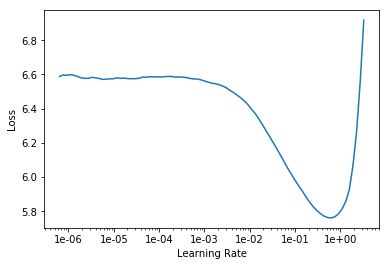

In [15]:
learn.recorder.plot(skip_end=5)

In [16]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.701764,4.069409,0.247670,00:11


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

Unfreeze the model and train further for fine-tuning.

In [0]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.993399,3.891858,0.272419,00:15
1,3.859320,3.768095,0.286970,00:14
2,3.702678,3.697409,0.293080,00:14
3,3.486637,3.665485,0.298549,00:15
4,3.229425,3.681240,0.298354,00:15
5,2.956508,3.739395,0.296177,00:15
6,2.704288,3.815150,0.292969,00:15
7,2.485577,3.872446,0.291127,00:15
8,2.335835,3.916708,0.288686,00:15
9,2.276927,3.931241,0.287835,00:15


We get an accuracy of almost 29% which means our model is able to predict the next word in a sentence with a probability of 29%.

In [0]:
learn.save('fine_tuned')

We do a sanity check and see how good our model is by seeing what it predicts after a few given words

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this airline because"
N_WORDS = 40
N_SENTENCES = 2

In [24]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this airline because i said my company did n't want to change the ticket . i book with you guys xxbos @jetblue @united my friend is there to assist . Might believe you are helping me . xxbos @usairways Awesome service
I liked this airline because i feel like you " do n't want to fix your " bad job and maintenance practices " xxbos @southwestair Yes , i am so impressed . Son has a pair of surgery in his left row .


We gave the model as well as its encoder, as this part is responsible for guessing the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

# Classifier Model

We create a new data object that grabs the labelled data and keeps those labels.

In [0]:
data_clas = TextClasDataBunch.from_csv(path, 'data.csv', vocab=data_lm.vocab)
             

In [27]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @southwestair i had to travel to xxmaj savannah , xxup xxunk , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj xxunk xxrep 4 e ase xxrep 4 !",neutral
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
"xxbos .@americanair ( 2 / 3 ) ... i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",negative


We can then create a model  to classify the tweets and load the encoder we saved before.


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc')

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


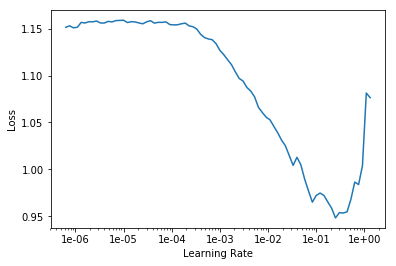

In [46]:
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.644669,0.553244,0.779447,00:06
1,0.594431,0.518366,0.792762,00:06


In [0]:
learn.save('first')

In [0]:
learn.load('first');

We unfreeze the model layer by layer for better fine-tuning.

In [50]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.619544,0.503611,0.800615,00:08
1,0.517357,0.484739,0.813930,00:08


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [53]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.480865,0.499605,0.814613,00:13
1,0.345403,0.492738,0.824513,00:13


In [0]:
learn.save('third')

In [0]:
learn.load('third');

We unfreeze the model completely and train.

In [56]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.267937,0.507504,0.824855,00:17
1,0.230925,0.557753,0.821099,00:16
2,0.208768,0.586803,0.821782,00:16
3,0.159748,0.638053,0.819734,00:17
4,0.122999,0.621429,0.819051,00:16


We get an accuracy of 82% which suggests our model is able to predict the correct sentiment in a tweet with 82% accuracy.

# Model Prediction

We run the model prediction on some sample tweets.

In [57]:
learn.predict("I really loved that airline, it was awesome!")

(Category positive, tensor(2), tensor([4.1145e-04, 1.9587e-06, 9.9959e-01]))

In [58]:
learn.predict("I hate taking flight at this airport")

(Category negative, tensor(0), tensor([9.9272e-01, 4.5996e-04, 6.8221e-03]))